In [40]:
import cv2
import numpy as np
import pickle
import matplotlib.image as mpimg
import glob
import imageio
import collections

from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.ndimage.measurements import label
from lesson_functions import bin_spatial, get_hog_features, color_hist
from lesson_functions import show_image, draw_boxes, convert_color

%matplotlib inline


with open(b"training_data.p", "rb") as f:
    data = pickle.load(f)
    svc = data['svc']
    X_scaler = data['X_scaler']
    color_space = data['color_space']
    spatial_size = data['spatial_size']
    hog_channel = data['hog_channel']
    pix_per_cell = data['pix_per_cell']
    cell_per_block = data['cell_per_block']
    orient = data['orient']
    hist_bins = data['hist_bins']
    print('Loading trained classifier with color space:', color_space)

Loading trained classifier with color space: HLS


In [29]:
def find_cars(img_ori, col_space, y_start, y_stop, i_scale, show=False, debug=False):

    img = img_ori.astype(np.float32) / 255
    img_tosearch = img[y_start:y_stop, :, :]

    img_tosearch_conv = convert_color(img_tosearch, col_space)
    if i_scale != 1:
        imshape = img_tosearch_conv.shape
        img_tosearch_conv = cv2.resize(img_tosearch_conv, (np.int(imshape[1] / i_scale), np.int(imshape[0] / i_scale)))

    # Compute individual channel HOG features for the entire image
    ch1 = img_tosearch_conv[:, :, 0]
    ch2 = img_tosearch_conv[:, :, 1]
    ch3 = img_tosearch_conv[:, :, 2]

    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step

            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(img_tosearch_conv[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))

            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft * i_scale)
                ytop_draw = np.int(ytop * i_scale)
                win_draw = np.int(window * i_scale)
                top_left = (xbox_left, ytop_draw+y_start)
                bottom_right = (xbox_left+win_draw, ytop_draw+win_draw+y_start)
                if debug:
                    print("Box", top_left, bottom_right)
                box_list.append((top_left, bottom_right))

                if show:
                    cv2.rectangle(img, (xbox_left, ytop_draw + y_start), (xbox_left + win_draw, ytop_draw + win_draw + y_start), (32, -9, -130), thickness=4)

    if show:
        show_image([img_ori, img], ['Original', 'Car Found'], cols=2)

    return box_list

In [38]:
prev_heat = collections.deque(maxlen=6)


def process_image(img, video=True, debug=False):

    #Find matching car in image
    box_list = []
    box_list += find_cars(img, color_space, 370, 500, 1)
    box_list += find_cars(img, color_space, 400, 580, 2)

    if debug:
        print('Box amount:', len(box_list))

    # add heat
    global prev_heat
    heat = np.zeros((720, 1280))  # hardcode for now
    for box in box_list:
        heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    prev_heat.append(heat)
    
    if debug:
        print('Heat shape', heat.shape)

    #generate heat
    heat = np.sum(np.array(prev_heat), axis=0)
    if len(prev_heat) == 6:
        heat[heat <= 3] = 0

    #label heat
    pix, n_car = label(heat)

    new_boxes = []
    for i in range(1, n_car + 1):
        nonzero = (pix == i).nonzero()

        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        box = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        new_boxes.append(box)


    img_box = draw_boxes(img, new_boxes)
    img_grid = draw_boxes(img, box_list)
    img_hot = np.hstack((heat, heat, heat)) 

    if debug:
        print("New boxes: ", new_boxes, 'pix:', pix.shape, 'n_car:', n_car)
        print('Shape:', img_hot.shape)
    
    #img_box = draw_boxes(img, box_list)
    # imsave cmap='hot' to save the heatmap
    # return np.hstack((img, hot))
    return img_box, img_grid, img_hot


File:  test_images/test6.jpg
Box amount: 150
Heat shape (720, 1280)
New boxes:  [((704, 378), (1247, 543)), ((144, 386), (415, 543))] pix: (720, 1280) n_car: 2
Shape: (720, 3840)


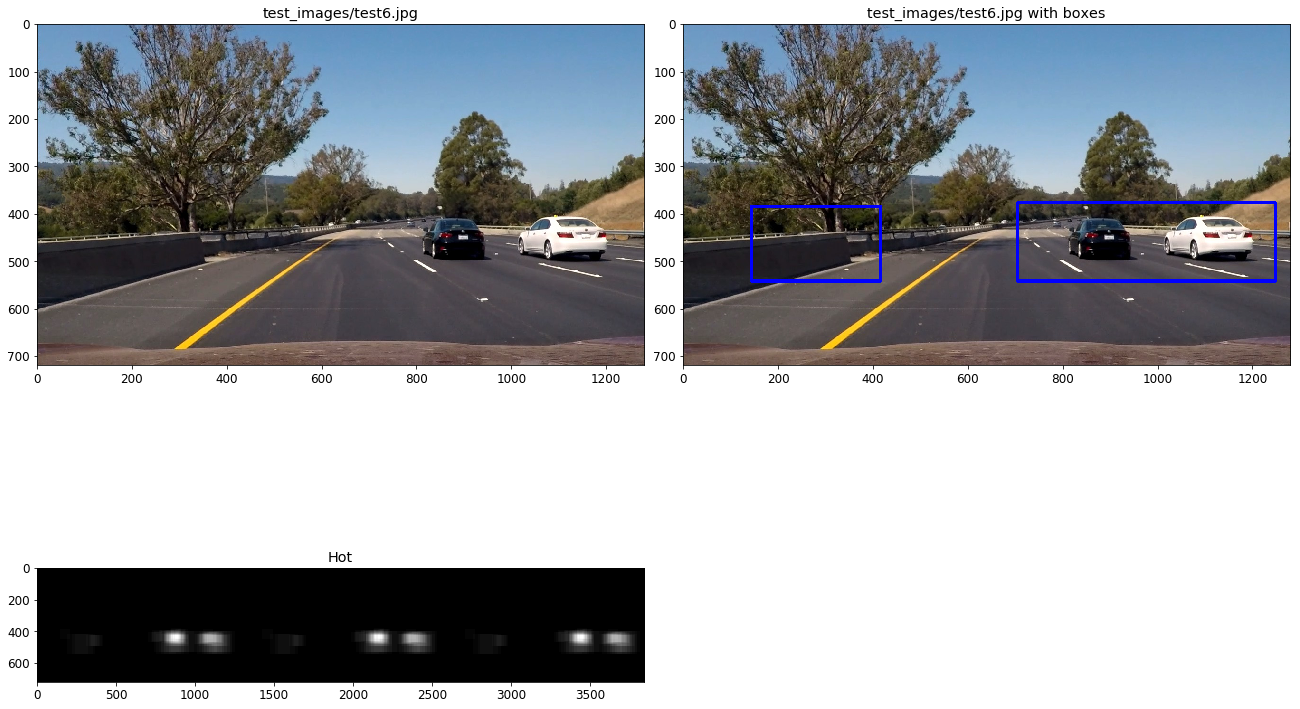

In [39]:
def test_classifier():
    path_list = glob.glob('test_images/*.jpg')
    selected_path = path_list[10]
    print('File: ', selected_path)
        
    img_test = mpimg.imread(selected_path)
    img_box, img_grid, img_hot = process_image(img_test, video=False, debug=True)
    show_image([img_test, img_box, img_hot], 
               [selected_path, selected_path+' with boxes', 'Hot'])
    
test_classifier()

In [6]:
def generate_video(video_in_name, video_out_name, start=0, stop=0):

    if stop > start:
        video_input = VideoFileClip(video_in_name).subclip(start, stop)
    else:
        video_input = VideoFileClip(video_in_name)

    video_proc = video_input.fl_image(process_image)    
    %time video_proc.write_videofile(video_out_name, audio=False)
    
    HTML("""
    <video width="960" height="540" controls>
        <source src="{0}">
    </video>
    """.format(video_out_name))
    
#generate_video('test_video.mp4', 'test_video_output.mp4')
generate_video('./project_video.mp4', './project_video_output.mp4', start=5, stop=20)


[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|███████████████████████████████████████████████████████████████████████████████▊| 375/376 [01:40<00:00,  3.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

Wall time: 1min 41s
